In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, BatchNorm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

data = torch.load('../data/processed/graph_data_full.pt', weights_only=False)
data = data.to(device)

print(f"Data Loaded: {data}")
print(f"Label 1 ratio (Delayed): {data.y.sum() / len(data.y):.2%}")


c:\Users\dangnguyen\Repo\flight-delay-gnn-system\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Data Loaded: Data(x=[273, 273], edge_index=[2, 190679], edge_attr=[190679, 10], y=[190679, 1])
Label 1 ratio (Delayed): 19.84%


In [2]:
print(f"Does Edge Features contain NaN? {torch.isnan(data.edge_attr).any()}")
print(f"Does Node Features contain NaN? {torch.isnan(data.x).any()}")
print(f"Does Label contain NaN? {torch.isnan(data.y).any()}")

if torch.isnan(data.edge_attr).any():
    print("DETECTED PROBLEMATIC COLUMNS:")
    feat_np = data.edge_attr.cpu().numpy()
    for i in range(feat_np.shape[1]):
        if np.isnan(feat_np[:, i]).any():
            print(f" - Column index {i} contains NaN")


Does Edge Features contain NaN? False
Does Node Features contain NaN? False
Does Label contain NaN? False


In [3]:
class FlightDelayGNN(torch.nn.Module):
    def __init__(self, num_nodes, input_edge_feats, hidden_dim, heads=2):
        super(FlightDelayGNN, self).__init__()
        
        self.node_emb = torch.nn.Linear(num_nodes, hidden_dim)
        

        self.edge_proj = torch.nn.Linear(input_edge_feats, hidden_dim)


        self.conv1 = GATv2Conv(hidden_dim, hidden_dim, heads=heads, 
                               concat=True, edge_dim=hidden_dim)
        self.bn1 = BatchNorm(hidden_dim * heads)
        
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, 
                               concat=False, edge_dim=hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim + input_edge_feats, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        x = self.node_emb(x)
        
        edge_attr_emb = self.edge_proj(edge_attr)
        

        x = self.conv1(x, edge_index, edge_attr=edge_attr_emb)
        x = self.bn1(x)
        x = F.elu(x) 
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index, edge_attr=edge_attr_emb)
        x = self.bn2(x)
        x = F.elu(x)
        

        src_idx, dst_idx = edge_index
        x_src = x[src_idx]
        x_dst = x[dst_idx]
        

        edge_cat = torch.cat([x_src, x_dst, edge_attr], dim=1)
        
        return self.decoder(edge_cat)


num_nodes = data.x.shape[0]  
input_edge_feats = data.edge_attr.shape[1] 
hidden_dim = 64
heads = 2

model = FlightDelayGNN(num_nodes, input_edge_feats, hidden_dim, heads=heads).to(device)
print(model)


FlightDelayGNN(
  (node_emb): Linear(in_features=273, out_features=64, bias=True)
  (edge_proj): Linear(in_features=10, out_features=64, bias=True)
  (conv1): GATv2Conv(64, 64, heads=2)
  (bn1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATv2Conv(128, 64, heads=1)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder): Sequential(
    (0): Linear(in_features=138, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [4]:
num_edges = data.num_edges
indices = torch.randperm(num_edges)

train_size = int(0.8 * num_edges)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

print(f"Train samples: {len(train_idx)}")
print(f"Test samples: {len(test_idx)}")

Train samples: 152543
Test samples: 38136


Starting training...
Epoch: 020, Loss: 1.0810, Train F1: 0.3349, Test F1: 0.3346
Epoch: 040, Loss: 1.0510, Train F1: 0.3405, Test F1: 0.3406
Epoch: 060, Loss: 1.0406, Train F1: 0.3707, Test F1: 0.3707
Epoch: 080, Loss: 1.0352, Train F1: 0.3775, Test F1: 0.3763
Epoch: 100, Loss: 1.0303, Train F1: 0.3827, Test F1: 0.3798
Epoch: 120, Loss: 1.0268, Train F1: 0.3877, Test F1: 0.3834
Epoch: 140, Loss: 1.0229, Train F1: 0.3927, Test F1: 0.3881
Epoch: 160, Loss: 1.0188, Train F1: 0.4039, Test F1: 0.3971
Epoch: 180, Loss: 1.0165, Train F1: 0.4013, Test F1: 0.3966
Epoch: 200, Loss: 1.0133, Train F1: 0.4068, Test F1: 0.4002
Epoch: 220, Loss: 1.0100, Train F1: 0.4168, Test F1: 0.4120
Epoch: 240, Loss: 1.0092, Train F1: 0.4189, Test F1: 0.4136
Epoch: 260, Loss: 1.0062, Train F1: 0.4227, Test F1: 0.4153
Epoch: 280, Loss: 1.0033, Train F1: 0.4106, Test F1: 0.4075
Epoch: 300, Loss: 1.0043, Train F1: 0.4091, Test F1: 0.4033
Epoch: 320, Loss: 1.0002, Train F1: 0.4079, Test F1: 0.4018
Epoch: 340, Loss: 0

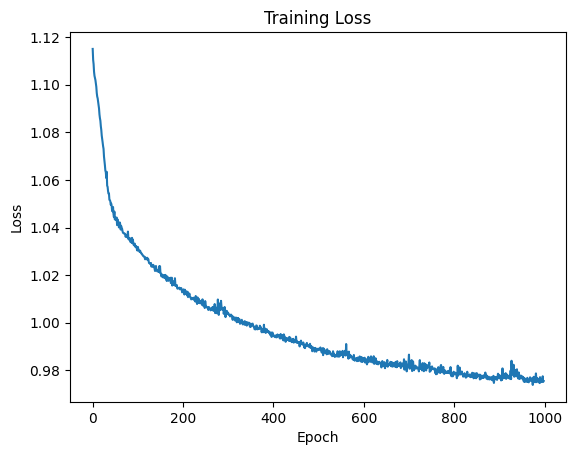

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


pos_weight = torch.tensor([4.0]).to(device) 
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def train():
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index, data.edge_attr)
    
    loss = criterion(out[train_idx], data.y[train_idx])
    
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(mask_idx):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    
    pred = (torch.sigmoid(out[mask_idx]) > 0.5).float()
    y_true = data.y[mask_idx]
    
    acc = accuracy_score(y_true.cpu(), pred.cpu())
    f1 = f1_score(y_true.cpu(), pred.cpu())
    return acc, f1

print("Starting training...")
losses = []
for epoch in range(1, 1000):
    loss = train()
    losses.append(loss)
    
    if epoch % 20 == 0:
        train_acc, train_f1 = test(train_idx)
        test_acc, test_f1 = test(test_idx)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [6]:
torch.save(model.state_dict(), '../state/models/gnn_flight_delay.pth')
print("Model saved")


Model saved
